#### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import itertools
import warnings

pd.set_option("display.float_format", lambda x: f"{x:,.4f}")
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)
warnings.filterwarnings("ignore")

#### Data

In [2]:
tx = pd.read_csv("merged-df.csv")                       # transactions
users = pd.read_csv("final_features_with_clusters.csv") # user-level with Cluster

print("tx shape:", tx.shape)
print("users shape:", users.shape)
print("tx columns:", tx.columns)
print("users columns:", users.columns)

tx shape: (13305915, 36)
users shape: (1219, 33)
tx columns: Index(['transaction_id', 'date', 'user_id', 'card_id', 'amount', 'use_chip', 'merchant_id', 'merchant_city',
       'merchant_state', 'zip', 'mcc', 'description', 'category', 'user_current_age', 'user_retirement_age',
       'user_birth_year', 'user_birth_month', 'user_gender', 'user_address', 'user_latitude', 'user_longitude',
       'user_per_capita_income', 'user_yearly_income', 'user_total_debt', 'user_credit_score', 'user_num_credit_cards',
       'card_card_brand', 'card_card_type', 'card_has_chip', 'card_cvv', 'card_expires', 'card_num_cards_issued',
       'card_credit_limit', 'card_acct_open_date', 'card_year_pin_last_changed', 'card_card_on_dark_web'],
      dtype='object')
users columns: Index(['user_id', 'total_txn_count', 'total_amount', 'avg_amount', 'std_amount', 'median_amount', 'first_txn',
       'last_txn', 'user_gender', 'user_current_age', 'user_birth_year', 'user_yearly_income',
       'user_per_capita_i

In [3]:
tx['date'] = pd.to_datetime(tx['date'], errors='coerce')
print("tx date range:", tx['date'].min(), "→", tx['date'].max())

tx date range: 2010-01-01 00:01:00 → 2019-10-31 23:59:00


#### Final df with clusters

In [4]:
cluster_map = users[['user_id', 'Cluster']].drop_duplicates()
df = tx.merge(cluster_map, on='user_id', how='left')

In [5]:
df

,transaction_id,date,user_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,description,category,user_current_age,user_retirement_age,user_birth_year,user_birth_month,user_gender,user_address,user_latitude,user_longitude,user_per_capita_income,user_yearly_income,user_total_debt,user_credit_score,user_num_credit_cards,card_card_brand,card_card_type,card_has_chip,card_cvv,card_expires,card_num_cards_issued,card_credit_limit,card_acct_open_date,card_year_pin_last_changed,card_card_on_dark_web,Cluster
0,7475327,2010-01-01 00:01:00,1556,2972,-77.0000,Swipe Transaction,59935,Beulah,ND,58523,5499,Miscellaneous Food Stores,Food & Dining,30,67,1989,7,Female,594 Mountain View Street,46.8000,-100.7600,"23,679.0000","48,277.0000","110,153.0000",740,4,Mastercard,Debit (Prepaid),YES,306,2022-07-01,2,55.0000,2008-05-01,2008,No,3
1,7475328,2010-01-01 00:02:00,561,4575,14.5700,Swipe Transaction,67570,Bettendorf,IA,52722,5311,Department Stores,Shopping & Retail,48,67,1971,6,Male,604 Pine Street,40.8000,-91.1200,"18,076.0000","36,853.0000","112,139.0000",834,5,Mastercard,Credit,YES,438,2024-12-01,1,"9,100.0000",2005-09-01,2015,No,3
2,7475329,2010-01-01 00:02:00,1129,102,80.0000,Swipe Transaction,27092,Vista,CA,92084,4829,Money Transfer,Financial & Insurance,49,65,1970,4,Male,2379 Forest Lane,33.1800,-117.2900,"16,894.0000","34,449.0000","36,540.0000",686,3,Mastercard,Debit,YES,256,2020-05-01,1,"14,802.0000",2006-01-01,2008,No,2
3,7475331,2010-01-01 00:05:00,430,2860,200.0000,Swipe Transaction,27092,Crown Point,IN,46307,4829,Money Transfer,Financial & Insurance,52,67,1967,5,Female,903 Hill Boulevard,41.4200,-87.3500,"26,168.0000","53,350.0000","128,676.0000",685,5,Mastercard,Debit,NO,54,2024-10-01,2,"37,634.0000",2004-05-01,2006,No,0
4,7475332,2010-01-01 00:06:00,848,3915,46.4100,Swipe Transaction,13051,Harwood,MD,20776,5813,Drinking Places (Alcoholic Beverages),Food & Dining,51,69,1968,5,Male,166 River Drive,38.8600,-76.6000,"33,529.0000","68,362.0000","96,182.0000",711,2,Visa,Debit,YES,120,2020-01-01,1,"19,113.0000",2009-07-01,2014,No,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13305910,23761868,2019-10-31 23:56:00,1718,2379,1.1100,Chip Transaction,86438,West Covina,CA,91792,5499,Miscellaneous Food Stores,Food & Dining,81,67,1938,11,Female,766 Third Drive,34.0200,-117.8900,"22,681.0000","33,483.0000",196.0000,698,5,Mastercard,Debit,YES,992,2020-02-01,1,"26,743.0000",2019-03-01,2019,No,0
13305911,23761869,2019-10-31 23:56:00,1766,2066,12.8000,Online Transaction,39261,ONLINE,Unknown,Unknown,5815,"Digital Goods - Media, Books, Apps",Entertainment & Recreation,62,66,1957,9,Male,6076 Bayview Boulevard,43.0600,-87.9600,"9,995.0000","20,377.0000","12,092.0000",789,4,Mastercard,Debit,YES,91,2024-06-01,1,"5,141.0000",2004-03-01,2012,No,1
13305912,23761870,2019-10-31 23:57:00,199,1031,40.4400,Swipe Transaction,2925,Allen,TX,75002,4900,"Utilities - Electric, Gas, Water, Sanitary",Home & Utilities,67,67,1952,4,Female,7927 Plum Lane,33.1000,-96.6600,"32,580.0000","78,329.0000","40,161.0000",720,3,Mastercard,Debit,YES,908,2021-06-01,1,"17,686.0000",2004-02-01,2007,No,1
13305913,23761873,2019-10-31 23:58:00,1986,5443,4.0000,Chip Transaction,46284,Daly City,CA,94014,5411,"Grocery Stores, Supermarkets",Food & Dining,44,69,1975,12,Female,5887 Seventh Lane,37.6800,-122.4300,"23,752.0000","48,430.0000","62,384.0000",716,2,Visa,Debit,YES,762,2021-11-01,2,"14,036.0000",2005-11-01,2010,No,1


#### exclude refunds (negative amounts)

In [6]:
import numpy as np
import pandas as pd

print("\n=== Proper refund exclusion (memory-friendly) ===")

df = df.copy()

# 1. Helper columns
df['abs_amount'] = df['amount'].abs()
group_cols = ['user_id', 'mcc', 'abs_amount']

# 2. Split into positives and negatives (but keep only minimal columns here)
pos = df[df['amount'] > 0][group_cols + ['transaction_id']].copy()
neg = df[df['amount'] < 0][group_cols + ['transaction_id']].copy()

# 3. For each (user_id, mcc, abs_amount) group, count negatives
neg_counts = (
    neg.groupby(group_cols)
       .size()
       .reset_index(name='n_neg')
)

# 4. Join neg_counts onto positives, then assign an order within each group
pos = pos.merge(neg_counts, on=group_cols, how='left')
pos['n_neg'] = pos['n_neg'].fillna(0).astype(int)

# position of each positive transaction within its group
pos['pos_order'] = pos.groupby(group_cols).cumcount()

# 5. Mark positives to drop:
#    drop exactly n_neg of them per group (the first ones)
matched_pos_ids = pos.loc[
    pos['pos_order'] < pos['n_neg'], 'transaction_id'
].to_numpy()

# 6. All negatives are dropped
neg_ids = neg['transaction_id'].to_numpy()

# 7. Build final mask
to_drop_ids = np.concatenate([matched_pos_ids, neg_ids])

before = len(df)
mask_keep = ~df['transaction_id'].isin(to_drop_ids)
df_clean = df[mask_keep].copy()
after = len(df_clean)

print(f"Matched positive rows removed: {len(matched_pos_ids):,}")
print(f"All negative rows removed:     {len(neg_ids):,}")
print(f"Total rows removed:            {before-after:,} "
      f"({100*(before-after)/before:.2f}%)")

# 8. Clean up
df_clean = df_clean.drop(columns=['abs_amount'], errors='ignore')

df = df_clean  # this is your refund-cleaned df


=== Proper refund exclusion (memory-friendly) ===
Matched positive rows removed: 659,751
All negative rows removed:     660,049
Total rows removed:            1,319,800 (9.92%)


#### Aggregate to Cluster × Month (target series)

We’re modeling total monthly spending per customer cluster. 

So the unit of prediction is cluster × month, not an individual’s transaction.

In [9]:
import pandas as pd

df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['month_end'] = (df['date'] + pd.offsets.MonthEnd(0)).dt.normalize()

In [11]:
cluster_monthly = (
    df.groupby(['Cluster', 'month_end'], as_index=False)['amount']
      .sum()
      .rename(columns={'month_end': 'date', 'amount': 'total_amount'})
      .sort_values(['Cluster', 'date'])
)

print(cluster_monthly.head())

   Cluster       date   total_amount
0        0 2010-01-31 1,125,217.0400
1        0 2010-02-28 1,072,219.5800
2        0 2010-03-31 1,174,035.9600
3        0 2010-04-30 1,129,380.2700
4        0 2010-05-31 1,171,273.1400


In [12]:
# 0) Make sure your 'date' is month-end aligned and datetime
cluster_monthly = cluster_monthly.copy()
cluster_monthly['date'] = pd.to_datetime(cluster_monthly['date']).dt.to_period('M').dt.to_timestamp('M')

# 1) Compute expected vs actual months per cluster correctly
def expected_months_count(start_ts, end_ts):
    return len(pd.period_range(start=start_ts, end=end_ts, freq='M'))  # inclusive count

ranges = (
    cluster_monthly.groupby('Cluster')['date']
    .agg(start='min', end='max')
    .reset_index()
)
ranges['expected_months'] = ranges.apply(lambda r: expected_months_count(r['start'], r['end']), axis=1)
actual = cluster_monthly.groupby('Cluster')['date'].nunique().reset_index(name='actual_months')
check = ranges.merge(actual, on='Cluster', how='left')
check['missing_months'] = check['expected_months'] - check['actual_months']
print(check)

   Cluster      start        end  expected_months  actual_months  missing_months
0        0 2010-01-31 2019-10-31              118            118               0
1        1 2010-01-31 2019-10-31              118            118               0
2        2 2010-01-31 2019-10-31              118            118               0
3        3 2010-01-31 2019-10-31              118            118               0


### No missing months in df

#### Quick EDA of composition

In [13]:
# Users' first/last txn and tenure (overview)
user_lifetimes = (
    df.groupby('user_id')['date']
      .agg(first_txn='min', last_txn='max')
      .reset_index()
)
user_lifetimes['tenure_days'] = (user_lifetimes['last_txn'] - user_lifetimes['first_txn']).dt.days
print(user_lifetimes['tenure_days'].describe())

count   1,219.0000
mean    3,491.8269
std       361.3578
min       852.0000
25%     3,589.0000
50%     3,590.0000
75%     3,590.0000
max     3,590.0000
Name: tenure_days, dtype: float64


- Most users were active through the full time range
- min = 852 --> A few joined late (maybe around 2017)

### Exploratory Analysis

#### 1. Total Spending Variation per Cluster

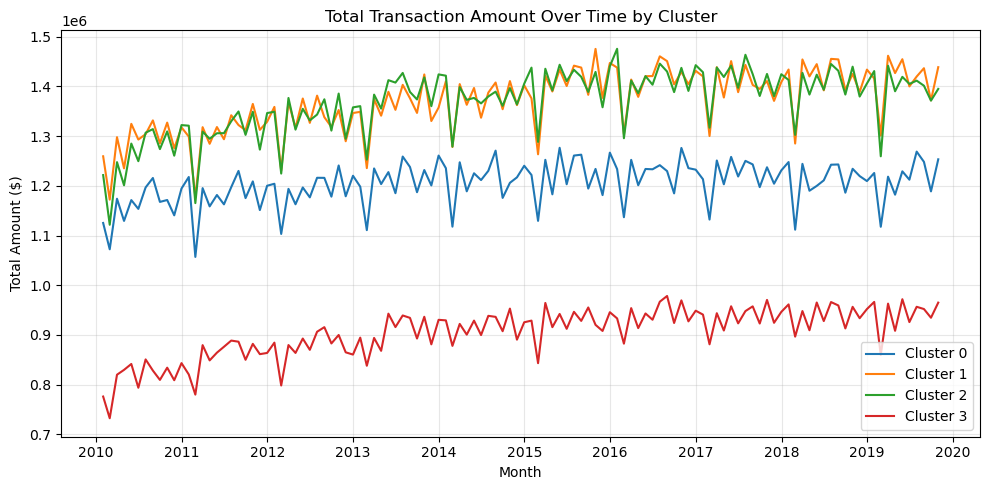

In [14]:
plt.figure(figsize=(10,5))

for c in cluster_monthly['Cluster'].unique():
    sub = cluster_monthly[cluster_monthly['Cluster']==c]
    plt.plot(sub['date'], sub['total_amount'], label=f'Cluster {c}')

plt.title('Total Transaction Amount Over Time by Cluster')
plt.xlabel('Month')
plt.ylabel('Total Amount ($)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

- exhibits seasonality
- clusters are separated by spending totals

#### 2. Rolling Mean & Variance per Cluster

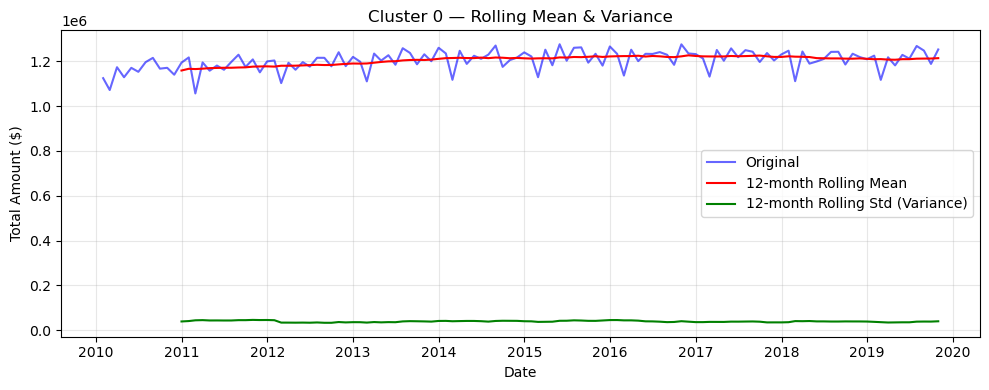

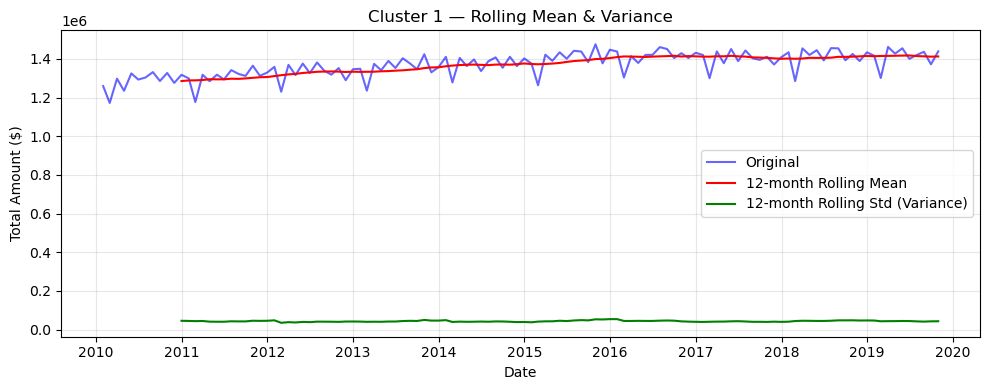

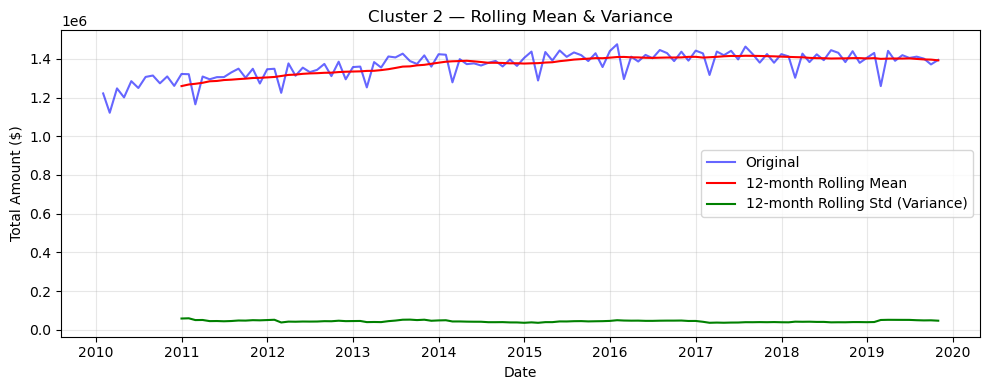

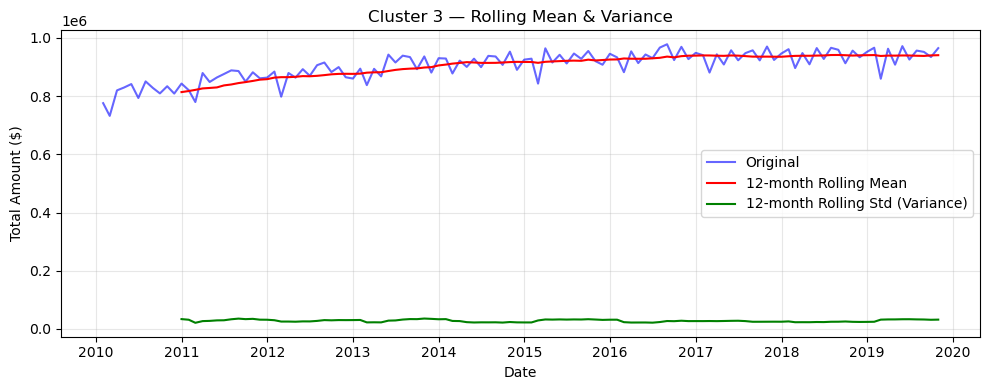

In [15]:
window = 12  # 12-month rolling window
for c in sorted(cluster_monthly['Cluster'].unique()):
    sub = cluster_monthly[cluster_monthly['Cluster']==c].set_index('date')['total_amount']
    rol_mean = sub.rolling(window).mean()
    rol_std  = sub.rolling(window).std()

    plt.figure(figsize=(10,4))
    plt.plot(sub, label='Original', color='blue', alpha=0.6)
    plt.plot(rol_mean, label=f'{window}-month Rolling Mean', color='red')
    plt.plot(rol_std, label=f'{window}-month Rolling Std (Variance)', color='green')
    plt.title(f'Cluster {c} — Rolling Mean & Variance')
    plt.xlabel('Date'); plt.ylabel('Total Amount ($)')
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

#### 3. Seasonal-Trend Decomposition (STL)

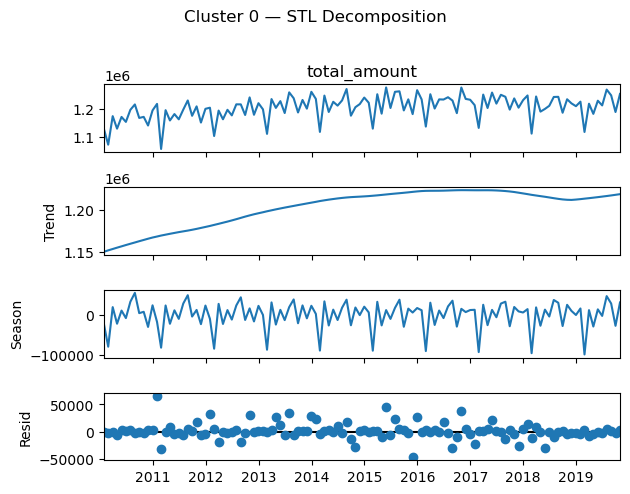

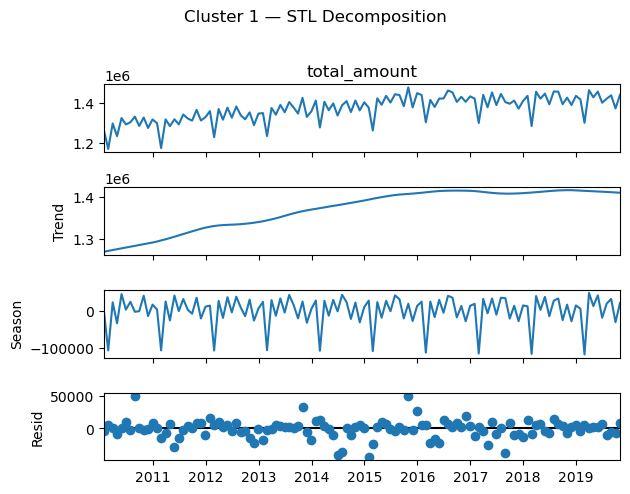

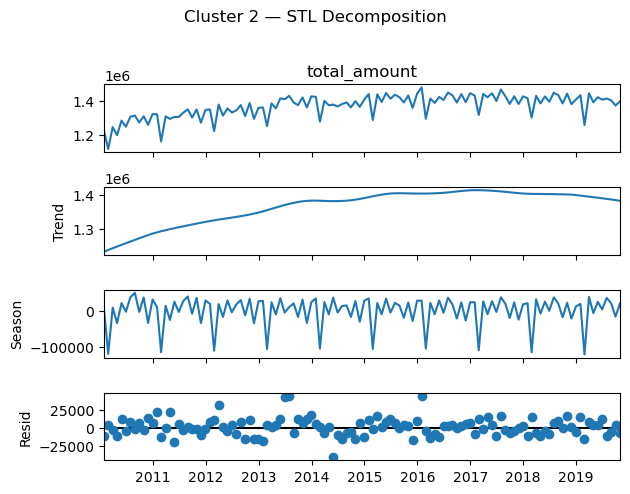

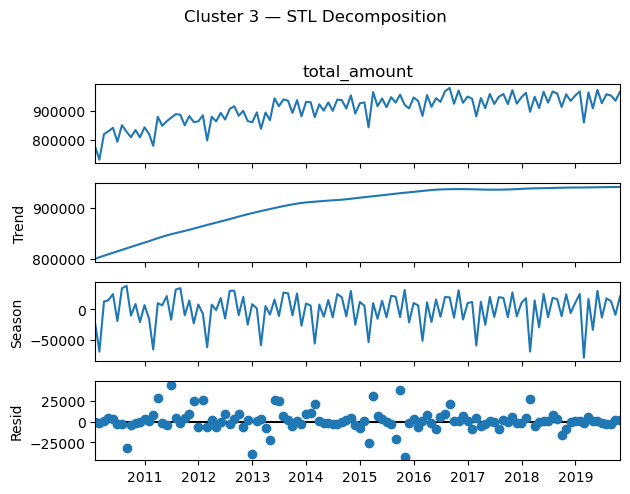

In [16]:
for c in sorted(cluster_monthly['Cluster'].unique()):
    sub = cluster_monthly[cluster_monthly['Cluster']==c].set_index('date')['total_amount']
    sub = sub.asfreq('M')  # ensure regular frequency
    stl = STL(sub, period=12, robust=True)
    res = stl.fit()
    res.plot()
    plt.suptitle(f'Cluster {c} — STL Decomposition', y=1.02)
    plt.tight_layout(); plt.show()

1. **Trend:** slow, upward trend across all clusters
2. **Seasonality:** strong, repeating 12-month pattern in every cluster
3. **Residuals:** randomly scattered

#### Formal Stationarity Check 

In [17]:
def adf_kpss_summary(ts):
    """Return a dict with ADF and KPSS test results for one series."""
    ts = ts.dropna()
    adf_stat, adf_p, *_ = adfuller(ts)
    kpss_stat, kpss_p, *_ = kpss(ts, regression='c', nlags='auto')
    return {
        "ADF_Statistic": adf_stat,
        "ADF_pvalue": adf_p,
        "ADF_Stationary": adf_p < 0.05,
        "KPSS_Statistic": kpss_stat,
        "KPSS_pvalue": kpss_p,
        "KPSS_Stationary": kpss_p > 0.05
    }

# Run tests for all clusters and collect results
rows = []
for cid in sorted(cluster_monthly["Cluster"].unique()):
    ts = (
        cluster_monthly[cluster_monthly["Cluster"] == cid]
        .set_index("date")["total_amount"]
        .asfreq("M")
    )
    result = adf_kpss_summary(ts)
    result["Cluster"] = cid
    rows.append(result)

# Convert to DataFrame for a clean table view
results_df = (
    pd.DataFrame(rows)
    .set_index("Cluster")
    .round(3)
)

In [18]:
display(results_df)

,ADF_Statistic,ADF_pvalue,ADF_Stationary,KPSS_Statistic,KPSS_pvalue,KPSS_Stationary
Cluster,,,,,,
0,-3.1620,0.0220,True,1.3900,0.0100,False
1,-2.1970,0.2070,False,1.7800,0.0100,False
2,-2.5830,0.0970,False,1.5730,0.0100,False
3,-5.3880,0.0000,True,1.5360,0.0100,False


#### Making the series stationary

In [19]:
cluster_monthly_diff1 = (
    cluster_monthly
    .groupby('Cluster', group_keys=False)
    .apply(lambda x: x.set_index('date')['total_amount'].diff().dropna())
)

In [20]:
rows_diff1 = []

for cid in sorted(cluster_monthly["Cluster"].unique()):
    ts = (
        cluster_monthly[cluster_monthly["Cluster"] == cid]
        .set_index("date")["total_amount"]
        .asfreq("M")
    )
    ts_diff = ts.diff().dropna()   # first differencing (remove trend)
    result = adf_kpss_summary(ts_diff)
    result["Cluster"] = cid
    rows_diff1.append(result)

results_diff1_df = (
    pd.DataFrame(rows_diff1)
    .set_index("Cluster")
    .round(3)
)

display(results_diff1_df)

,ADF_Statistic,ADF_pvalue,ADF_Stationary,KPSS_Statistic,KPSS_pvalue,KPSS_Stationary
Cluster,,,,,,
0,-12.0510,0.0000,True,0.0980,0.1000,True
1,-3.9690,0.0020,True,0.0890,0.1000,True
2,-2.7310,0.0690,False,0.3370,0.1000,True
3,-3.7490,0.0030,True,0.0590,0.1000,True


In [21]:
final_rows = []
for cid in sorted(cluster_monthly["Cluster"].unique()):
    ts = (
        cluster_monthly[cluster_monthly["Cluster"] == cid]
        .set_index("date")["total_amount"]
        .asfreq("M")
    )
    # d=1 for clusters 0/1/3, d=2 for cluster 2
    ts_used = ts.diff().dropna() if cid != 2 else ts.diff().diff().dropna()
    res = adf_kpss_summary(ts_used)
    res["Cluster"] = cid
    res["Used_d"]  = 1 if cid != 2 else 2
    final_rows.append(res)

final_stationarity = (
    pd.DataFrame(final_rows)
      .set_index("Cluster")
      .round(3)
)[["Used_d", "ADF_Statistic", "ADF_pvalue", "ADF_Stationary",
   "KPSS_Statistic", "KPSS_pvalue", "KPSS_Stationary"]]

display(final_stationarity)

,Used_d,ADF_Statistic,ADF_pvalue,ADF_Stationary,KPSS_Statistic,KPSS_pvalue,KPSS_Stationary
Cluster,,,,,,,
0,1,-12.0510,0.0000,True,0.0980,0.1000,True
1,1,-3.9690,0.0020,True,0.0890,0.1000,True
2,2,-10.1530,0.0000,True,0.1850,0.1000,True
3,1,-3.7490,0.0030,True,0.0590,0.1000,True


#### Finding (p, q)

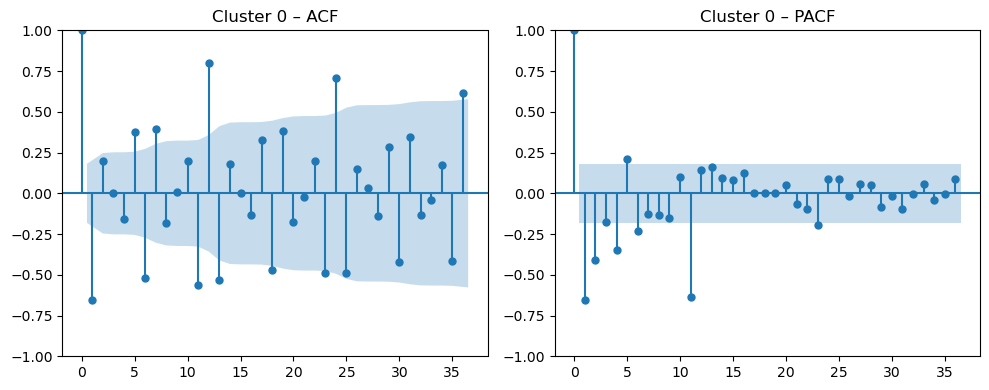

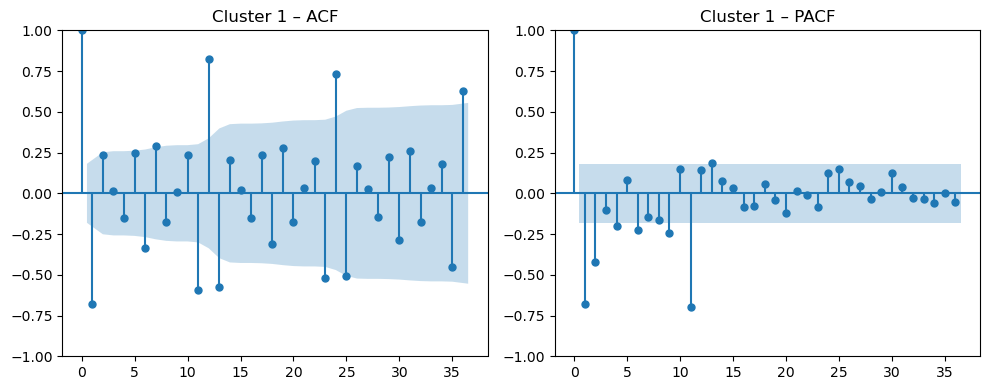

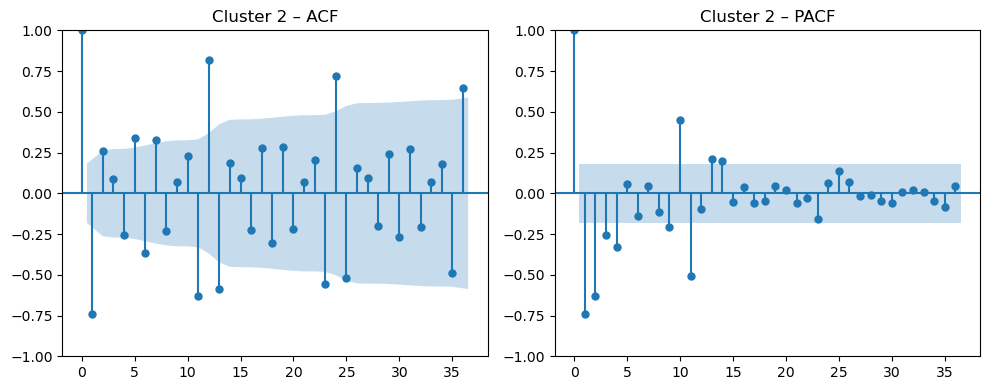

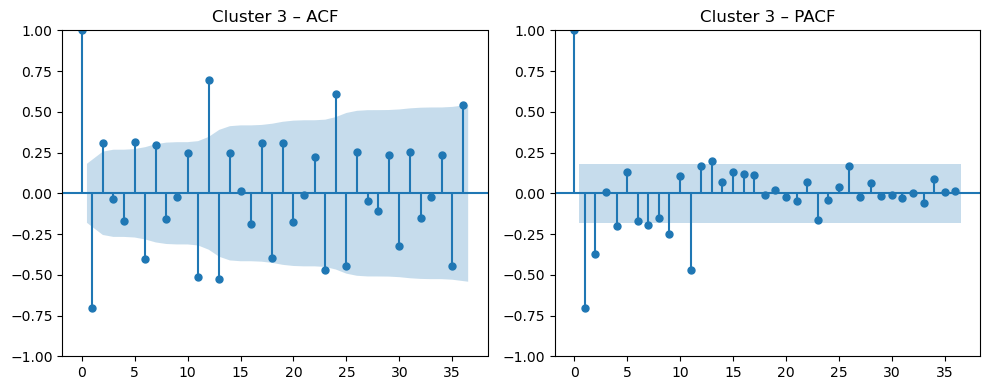

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

for cid in sorted(cluster_monthly["Cluster"].unique()):
    ts = (cluster_monthly[cluster_monthly["Cluster"] == cid]
          .set_index("date")["total_amount"]
          .asfreq("M"))
    z = ts.diff().dropna() if cid != 2 else ts.diff().diff().dropna()
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    plot_acf(z, lags=36, ax=ax[0]); ax[0].set_title(f"Cluster {cid} – ACF")
    plot_pacf(z, lags=36, ax=ax[1], method="ywm"); ax[1].set_title(f"Cluster {cid} – PACF")
    plt.tight_layout(); plt.show()

#### Moving to SARIMA

#### Finding parameter values for SARIMA

In [23]:
d_map = {0:1, 1:1, 2:1, 3:1}
S = 12
p = q = range(0, 3)     # nonseasonal orders
P = Q = range(0, 2)     # seasonal orders
USE_AICC = False        # set True to use AICc instead of BIC

In [24]:
def aicc_from_fit(n, k, aic):
    denom = n - k - 1
    return aic if denom <= 0 else aic + 2 * k * (k + 1) / denom

def try_fit(ts, order, seas_order):
    """Fit SARIMA and return metrics for selection."""
    try:
        res = SARIMAX(
            ts, order=order, seasonal_order=seas_order,
            enforce_stationarity=False, enforce_invertibility=False,
            simple_differencing=True
        ).fit(disp=False)

        resid = res.resid.dropna()
        lb = sm.stats.acorr_ljungbox(resid, lags=[S, 2*S], return_df=True)
        lb_p = float(lb["lb_pvalue"].iloc[-1])
        n = len(ts.dropna())
        k = res.params.size
        bic, aic = res.bic, res.aic
        aicc = aicc_from_fit(n, k, aic)

        return dict(success=True, res=res, bic=bic, aic=aic, aicc=aicc,
                    lb_p=lb_p, k=k)
    except Exception:
        return dict(success=False)

In [25]:
# grid search
rows, best_models = [], {}

for cid in sorted(cluster_monthly["Cluster"].unique()):
    ts = (
        cluster_monthly[cluster_monthly["Cluster"] == cid]
        .set_index("date")["total_amount"]
        .asfreq("M")
        .dropna()
    )
    d = d_map[cid]

    cand = []
    for p_, q_, P_, Q_ in itertools.product(p, q, P, Q):
        order = (p_, d, q_)
        seas  = (P_, 0, Q_, S)       # D=0 confirmed
        fit = try_fit(ts, order, seas)
        if fit["success"]:
            fit.update(order=order, seasonal_order=seas)
            cand.append(fit)

    assert len(cand) > 0, f"No models converged for cluster {cid}"

    # (1) prefer white-noise residuals
    ok = [c for c in cand if c["lb_p"] >= 0.05] or cand

    # (2) choose lowest IC; tie-break by fewer params, then AIC
    key_ic = (lambda x: x["aicc"]) if USE_AICC else (lambda x: x["bic"])
    ok.sort(key=lambda c: (key_ic(c), c["k"], c["aic"]))
    best = ok[0]
    best_models[cid] = best["res"]

    rows.append({
        "Cluster": cid,
        "Best_Order": best["order"],
        "Best_Seasonal": best["seasonal_order"],
        "BIC": round(best["bic"], 3),
        "AIC": round(best["aic"], 3),
        "AICc": round(best["aicc"], 3),
        "LB_p(S,2S)": round(best["lb_p"], 3),
        "Num_Params": int(best["k"]),
        "IC_Used": "AICc" if USE_AICC else "BIC"
    })

best_table = pd.DataFrame(rows).set_index("Cluster")
display(best_table)

,Best_Order,Best_Seasonal,BIC,AIC,AICc,"LB_p(S,2S)",Num_Params,IC_Used
Cluster,,,,,,,,
0,"(2, 1, 2)","(1, 0, 1, 12)","2,389.0420","2,370.6680","2,371.6860",0.7200,7,BIC
1,"(2, 1, 2)","(1, 0, 1, 12)","2,418.7110","2,400.3360","2,401.3540",0.7290,7,BIC
2,"(2, 1, 2)","(1, 0, 1, 12)","2,411.3760","2,393.0010","2,394.0200",0.8150,7,BIC
3,"(2, 1, 2)","(1, 0, 1, 12)","2,334.7910","2,316.4160","2,317.4340",0.7470,7,BIC


#### Model

- Rolling 1-month-ahead forecasts over 7-year training windows
- Using 12 month training period and 13th month to predict is too short to capture trends (growth) and seasonality
- data spans a decade, a 12-month window would miss longer-term patterns

In [26]:
def rolling_forecast(ts, order, seasonal_order, train_len=36, horizon=1, step=1):
    ts = ts.asfreq('M').dropna()
    n = len(ts)
    preds, actuals, stamps = [], [], []

    for start in range(0, n - train_len - horizon + 1, step):
        train = ts.iloc[start : start + train_len]
        test  = ts.iloc[start + train_len : start + train_len + horizon]

        try:
            model = SARIMAX(
                train,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False
            ).fit(disp=False)

            fc = model.forecast(steps=horizon)
            # horizon=1 → compare the next month
            preds.append(fc.iloc[0])
            actuals.append(test.iloc[0])
            stamps.append(test.index[0])

        except Exception:
            preds.append(np.nan)
            actuals.append(np.nan)
            stamps.append(test.index[0])

    df = pd.DataFrame({"timestamp": stamps, "Actual": actuals, "Pred": preds}).dropna()
    return df

In [27]:
ORDER = (2, 1, 2)
SEASONAL = (1, 0, 1, 12)

rows = []
for cid in sorted(cluster_monthly["Cluster"].unique()):
    ts = (
        cluster_monthly
        .query("Cluster == @cid")
        .set_index("date")["total_amount"]
        .asfreq("M")
        .dropna()
    )

    df_fc = rolling_forecast(
        ts,
        order=ORDER,
        seasonal_order=SEASONAL,
        train_len=36,   # ~3 years
        horizon=1,
        step=1
    )

    mae  = mean_absolute_error(df_fc["Actual"], df_fc["Pred"])
    mse  = mean_squared_error(df_fc["Actual"], df_fc["Pred"])
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(df_fc["Actual"], df_fc["Pred"]) * 100

    rows.append({
        "Cluster": cid,
        "n_forecasts": len(df_fc),
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "MAPE (%)": mape
    })

metrics_df = (
    pd.DataFrame(rows)
      .set_index("Cluster")
      .round({"MAE": 2, "MSE": 2, "RMSE": 2, "MAPE (%)": 2})
)
display(metrics_df)

,n_forecasts,MAE,MSE,RMSE,MAPE (%)
Cluster,,,,,
0,82,"27,265.5400","1,239,540,812.5600","35,207.1100",2.2500
1,82,"31,433.4700","1,816,205,486.9200","42,616.9600",2.2500
2,82,"25,289.8700","1,047,949,492.9600","32,372.0500",1.8200
3,82,"20,945.4400","672,831,279.3100","25,938.9900",2.2600


##### Why are MSE, RMSE, and MAE so large?
- scale of prediction: sum of all monthly transactions across users in each cluster.
- cluster-level totals are in millions of dollars, so naturally, errors are also in tens of thousands.
- Cluster 0’s RMSE ≈ 33K on a typical monthly spend of ~1.8 M, i.e., only ~1.8% relative error.

#### Normalizing Errors

In [32]:
# number of users per cluster (unique users)
user_counts = df.groupby('Cluster')['user_id'].nunique()

# attach to metrics_df, assuming metrics_df index = Cluster
metrics_df['user_count'] = metrics_df.index.map(user_counts)

# per-user normalized metrics
metrics_df['MAE_per_user']  = metrics_df['MAE']  / metrics_df['user_count']
metrics_df['RMSE_per_user'] = metrics_df['RMSE'] / metrics_df['user_count']

metrics_df = metrics_df.round({
    'MAE': 2, 'MSE': 2, 'RMSE': 2, 'MAPE (%)': 2,
    'MAE_per_user': 2, 'RMSE_per_user': 2
})

display(metrics_df[['MAE', 'RMSE', 'MAPE (%)',
                    'user_count', 'MAE_per_user', 'RMSE_per_user']])

,MAE,RMSE,MAPE (%),user_count,MAE_per_user,RMSE_per_user
Cluster,,,,,,
0,"27,265.5400","35,207.1100",2.2500,177,154.0400,198.9100
1,"31,433.4700","42,616.9600",2.2500,540,58.2100,78.9200
2,"25,289.8700","32,372.0500",1.8200,295,85.7300,109.7400
3,"20,945.4400","25,938.9900",2.2600,207,101.1900,125.3100


- approximate per user values (because the error still comes from cluster totals in the thousands or millions of dollar)
- MAPE is a better metric to evaluate (relative error)

#### Actual vs Predicted (per cluster)

In [33]:
def plot_actual_vs_pred(ts, order, seasonal_order, train_len=36, title_prefix=""):
    # Get rolling 1-step forecasts and align to time
    df_fc = rolling_forecast(ts, order, seasonal_order, train_len=train_len, horizon=1, step=1)
    # predictions correspond to the last len(df_fc) timestamps
    pred_index = ts.index[-len(df_fc):]
    df_fc = df_fc.set_index(pred_index)

    plt.figure(figsize=(10,4))
    plt.plot(ts.index, ts.values, label="Actual", linewidth=1.5)
    plt.plot(df_fc.index, df_fc["Pred"].values, label="Predicted (1-mo ahead)", linewidth=1.5)
    plt.title(f"{title_prefix}Actual vs Predicted (rolling 1-step)")
    plt.xlabel("Date"); plt.ylabel("Monthly Total Amount")
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()
    plt.show()

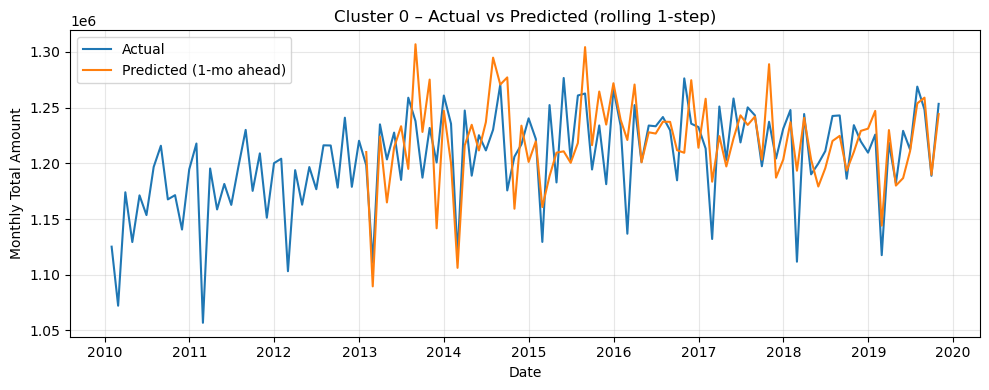

In [34]:
cid = 0
ts0 = (cluster_monthly.query("Cluster == @cid")
        .set_index("date")["total_amount"].asfreq("M").dropna())
plot_actual_vs_pred(ts0, order=(2,1,2), seasonal_order=(1,0,1,12),
                     train_len=36, title_prefix=f"Cluster {cid} – ")

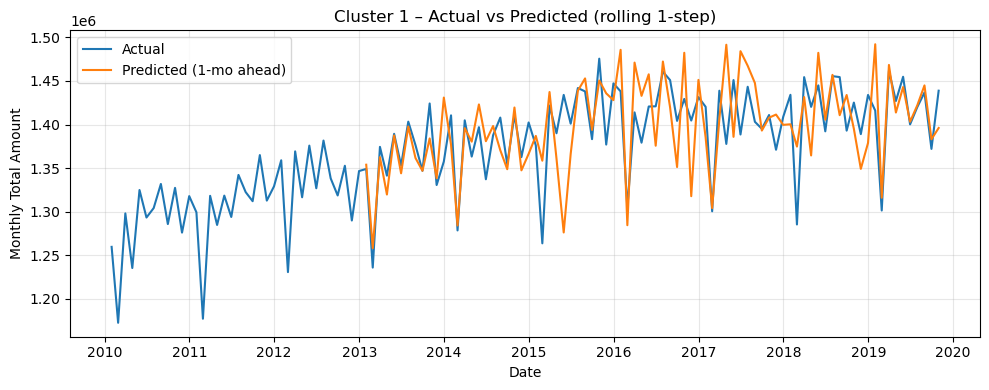

In [35]:
cid = 1
ts0 = (cluster_monthly.query("Cluster == @cid")
        .set_index("date")["total_amount"].asfreq("M").dropna())
plot_actual_vs_pred(ts0, order=(2,1,2), seasonal_order=(1,0,1,12),
                     train_len=36, title_prefix=f"Cluster {cid} – ")

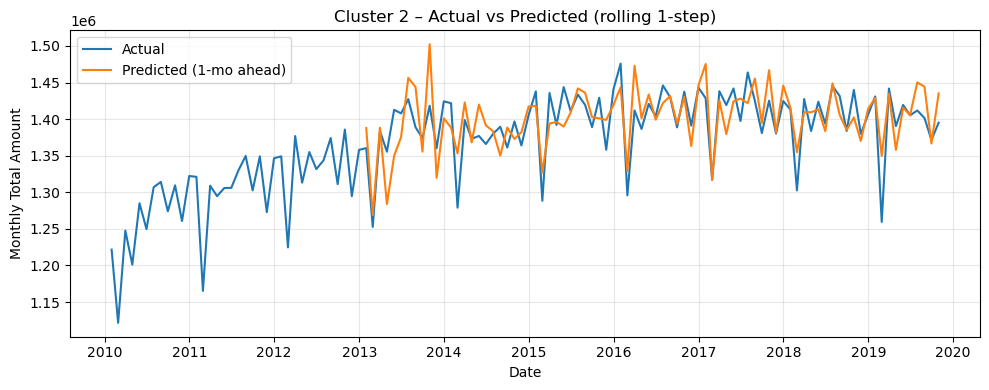

In [36]:
cid = 2
ts0 = (cluster_monthly.query("Cluster == @cid")
        .set_index("date")["total_amount"].asfreq("M").dropna())
plot_actual_vs_pred(ts0, order=(2,1,2), seasonal_order=(1,0,1,12),
                     train_len=36, title_prefix=f"Cluster {cid} – ")

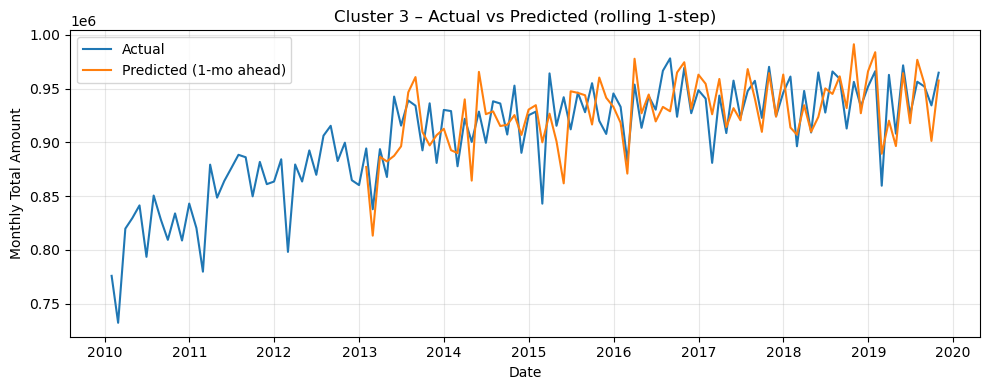

In [37]:
cid = 3
ts0 = (cluster_monthly.query("Cluster == @cid")
        .set_index("date")["total_amount"].asfreq("M").dropna())
plot_actual_vs_pred(ts0, order=(2,1,2), seasonal_order=(1,0,1,12),
                     train_len=36, title_prefix=f"Cluster {cid} – ")

#### All clusters overlay grid

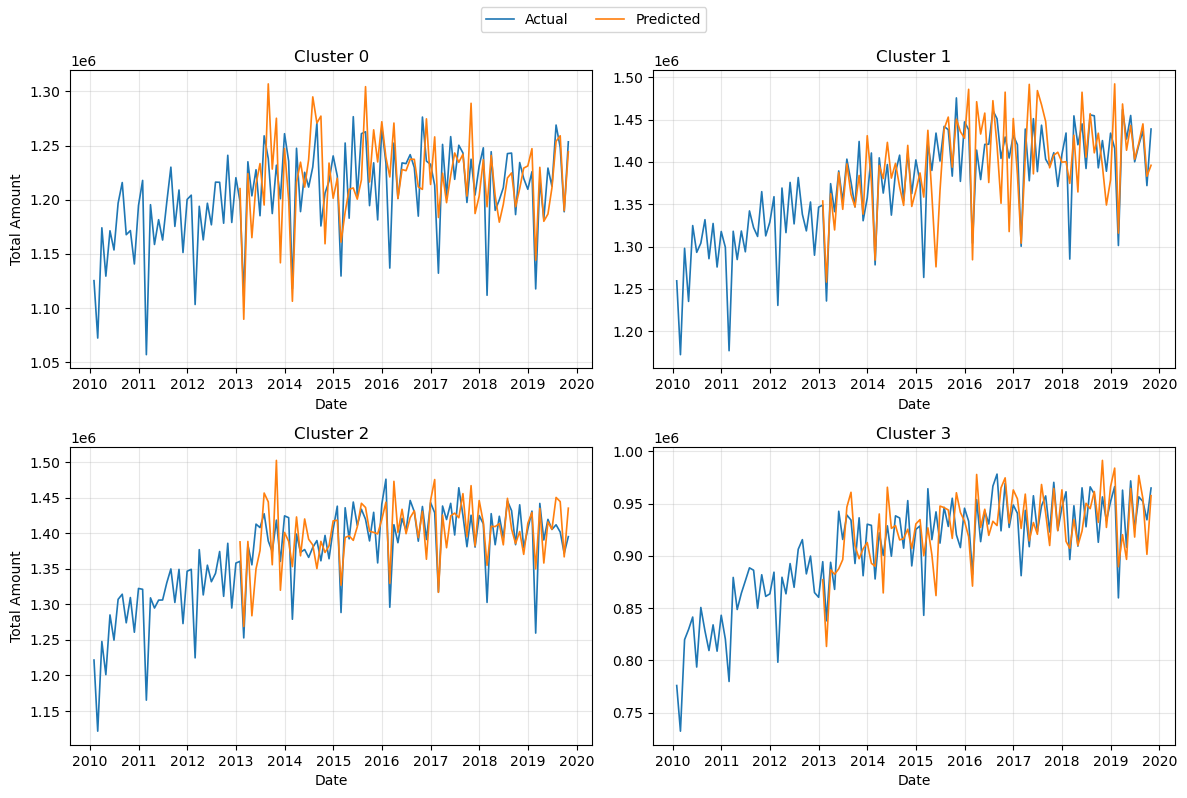

In [38]:
def plot_all_clusters_overlays(cluster_monthly, order, seasonal_order, train_len=36):
    cids = sorted(cluster_monthly["Cluster"].unique())
    n = len(cids)
    cols = 2
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows), squeeze=False)
    for i, cid in enumerate(cids):
        ax = axes[i // cols][i % cols]
        ts = (cluster_monthly.query("Cluster == @cid")
              .set_index("date")["total_amount"].asfreq("M").dropna())

        df_fc = rolling_forecast(ts, order, seasonal_order, train_len=train_len, horizon=1, step=1)
        pred_index = ts.index[-len(df_fc):]
        df_fc = df_fc.set_index(pred_index)

        ax.plot(ts.index, ts.values, label="Actual", linewidth=1.2)
        ax.plot(df_fc.index, df_fc["Pred"].values, label="Predicted", linewidth=1.2)
        ax.set_title(f"Cluster {cid}")
        ax.grid(alpha=0.3)
        if i % cols == 0: ax.set_ylabel("Total Amount")
        ax.set_xlabel("Date")

    # one legend for all
    handles, labels = axes[0][0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=2)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_all_clusters_overlays(cluster_monthly, order=(2,1,2), seasonal_order=(1,0,1,12), train_len=36)

### refund matching understanding - (not to be included in the final)

In [39]:
# Build refund matching summary
summary = (
    neg.groupby(group_cols)
       .size()
       .reset_index(name='neg_count')
    .merge(
        pos.groupby(group_cols).size().reset_index(name='pos_count'),
        on=group_cols,
        how='outer'
    )
    .fillna(0)
)

# How many positives actually got removed (full matches)
summary['matched_pairs'] = summary[['neg_count', 'pos_count']].min(axis=1)

# Unmatched negatives (e.g., partial refunds, no matching purchase)
summary['unmatched_neg'] = summary['neg_count'] - summary['matched_pairs']

# Unmatched positives (normal; means more purchases than refunds)
summary['unmatched_pos'] = summary['pos_count'] - summary['matched_pairs']

summary = summary.sort_values('matched_pairs', ascending=False)

In [40]:
summary

,user_id,mcc,abs_amount,neg_count,pos_count,matched_pairs,unmatched_neg,unmatched_pos
8019294,1888,5499,81.0000,129.0000,130.0000,129.0000,0.0000,1.0000
8018309,1888,5499,69.0000,128.0000,132.0000,128.0000,0.0000,4.0000
8023302,1888,5541,87.0000,127.0000,127.0000,127.0000,0.0000,0.0000
8023175,1888,5541,85.0000,125.0000,126.0000,125.0000,0.0000,1.0000
8020215,1888,5499,97.0000,125.0000,127.0000,125.0000,0.0000,2.0000
...,...,...,...,...,...,...,...,...
2873486,704,5541,219.3800,0.0000,1.0000,0.0000,0.0000,1.0000
2873485,704,5541,219.2600,0.0000,1.0000,0.0000,0.0000,1.0000
2873484,704,5541,219.0900,0.0000,1.0000,0.0000,0.0000,1.0000
2873483,704,5541,218.0300,0.0000,1.0000,0.0000,0.0000,1.0000
